In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [2]:
path = './data'

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# data_dir = './data/cifar10'

# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/train")
# print(classes)

In [7]:
# dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [9]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


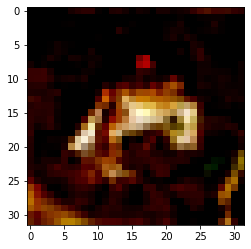

In [10]:
show_example(*trainset[0])

Label:  automobile (1)


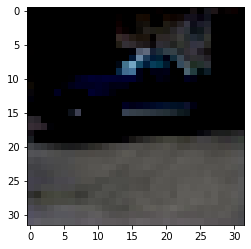

In [11]:
show_example(*trainset[10000])

# Training and Validation Datasets

In [12]:
random_seed = 42
torch.manual_seed(random_seed);

In [13]:
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [14]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

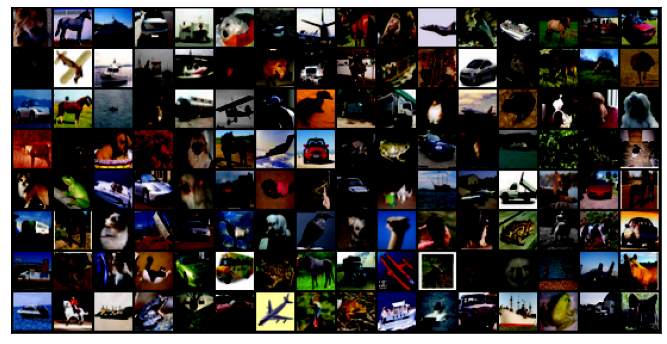

In [17]:
show_batch(train_dl)

# Building the CNN Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_acc: {:.4f}, val_acc: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_acc'], result['val_acc'], result['train_loss'], result['val_loss']))
        
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [53]:
class CNN_base(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [54]:
model = CNN_base()
model

CNN_base(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1536, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Integrating with GPU

In [55]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [56]:
device = get_default_device()
device

device(type='cuda')

In [57]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [58]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            
            # Compute gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [59]:
from torchsummary import summary

In [60]:
model = to_device(CNN_base(), device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [61]:
evaluate(model, val_dl)

{'val_loss': 2.3071060180664062, 'val_acc': 0.09989659488201141}

# Training the Baseline

In [62]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [63]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.4135, val_acc: 0.5334, train_loss: 1.6031, val_loss: 1.3058
Epoch [1], train_acc: 0.5779, val_acc: 0.6055, train_loss: 1.1798, val_loss: 1.1020
Epoch [2], train_acc: 0.6511, val_acc: 0.6649, train_loss: 0.9858, val_loss: 0.9453
Epoch [3], train_acc: 0.6954, val_acc: 0.6666, train_loss: 0.8690, val_loss: 0.9170
Epoch [4], train_acc: 0.7284, val_acc: 0.7096, train_loss: 0.7802, val_loss: 0.8302
Epoch [5], train_acc: 0.7509, val_acc: 0.7229, train_loss: 0.7128, val_loss: 0.7759
Epoch [6], train_acc: 0.7742, val_acc: 0.7166, train_loss: 0.6453, val_loss: 0.7915
Epoch [7], train_acc: 0.7939, val_acc: 0.7393, train_loss: 0.5946, val_loss: 0.7458
Epoch [8], train_acc: 0.8120, val_acc: 0.7418, train_loss: 0.5394, val_loss: 0.7456
Epoch [9], train_acc: 0.8248, val_acc: 0.7434, train_loss: 0.4987, val_loss: 0.7506
Epoch [10], train_acc: 0.8414, val_acc: 0.7452, train_loss: 0.4528, val_loss: 0.7653
Epoch [11], train_acc: 0.8572, val_acc: 0.7484, train_loss: 0.4122, val_los

In [64]:
def plot_accuracies(history):
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

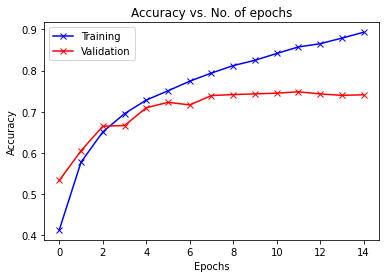

In [65]:
plot_accuracies(history)

In [66]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

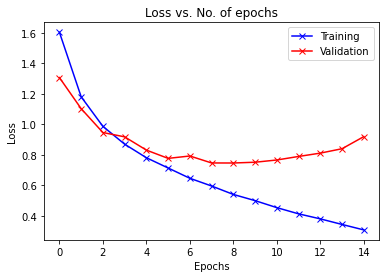

In [67]:
plot_losses(history)

# Experiments and Analysis

## With Batchnorm

In [73]:
class CNN_batchnorm(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
       
    def forward(self, xb):
        return self.network(xb)

In [74]:
model2 = to_device(CNN_batchnorm(), device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [75]:
%%time
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.5512, val_acc: 0.6338, train_loss: 1.2451, val_loss: 1.0326
Epoch [1], train_acc: 0.6945, val_acc: 0.6996, train_loss: 0.8737, val_loss: 0.8513
Epoch [2], train_acc: 0.7431, val_acc: 0.7151, train_loss: 0.7369, val_loss: 0.8034
Epoch [3], train_acc: 0.7740, val_acc: 0.6635, train_loss: 0.6514, val_loss: 0.9917
Epoch [4], train_acc: 0.7995, val_acc: 0.7493, train_loss: 0.5741, val_loss: 0.7133
Epoch [5], train_acc: 0.8244, val_acc: 0.7287, train_loss: 0.5076, val_loss: 0.8359
Epoch [6], train_acc: 0.8415, val_acc: 0.7529, train_loss: 0.4553, val_loss: 0.7194
Epoch [7], train_acc: 0.8592, val_acc: 0.7658, train_loss: 0.4065, val_loss: 0.6971
Epoch [8], train_acc: 0.8790, val_acc: 0.7472, train_loss: 0.3510, val_loss: 0.8161
Epoch [9], train_acc: 0.8893, val_acc: 0.7521, train_loss: 0.3158, val_loss: 0.8032
Epoch [10], train_acc: 0.9056, val_acc: 0.7683, train_loss: 0.2722, val_loss: 0.7480
Epoch [11], train_acc: 0.9178, val_acc: 0.7636, train_loss: 0.2354, val_los

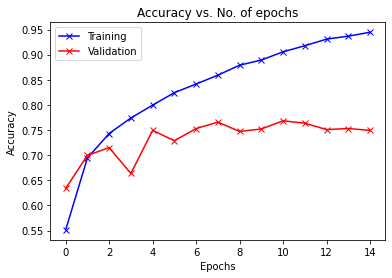

In [76]:
plot_accuracies(history2)

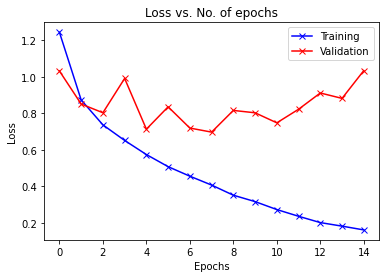

In [77]:
plot_losses(history2)

## With dropout

In [100]:
class CNN_batchnorm_dropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10))

    def forward(self, xb):
        return self.network(xb)


In [84]:
model3 = to_device(CNN_batchnorm_dropout(), device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [85]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [86]:
%%time
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.5157, val_acc: 0.6148, train_loss: 1.3434, val_loss: 1.0711
Epoch [1], train_acc: 0.6540, val_acc: 0.6835, train_loss: 0.9858, val_loss: 0.8929
Epoch [2], train_acc: 0.7020, val_acc: 0.7082, train_loss: 0.8486, val_loss: 0.8364
Epoch [3], train_acc: 0.7300, val_acc: 0.7119, train_loss: 0.7669, val_loss: 0.8249
Epoch [4], train_acc: 0.7535, val_acc: 0.7316, train_loss: 0.6997, val_loss: 0.7684
Epoch [5], train_acc: 0.7762, val_acc: 0.7337, train_loss: 0.6427, val_loss: 0.7994
Epoch [6], train_acc: 0.7898, val_acc: 0.7361, train_loss: 0.5968, val_loss: 0.7524
Epoch [7], train_acc: 0.8044, val_acc: 0.7212, train_loss: 0.5537, val_loss: 0.7970
Epoch [8], train_acc: 0.8135, val_acc: 0.7783, train_loss: 0.5207, val_loss: 0.6603
Epoch [9], train_acc: 0.8312, val_acc: 0.7763, train_loss: 0.4798, val_loss: 0.6584
Epoch [10], train_acc: 0.8428, val_acc: 0.7662, train_loss: 0.4417, val_loss: 0.6953
Epoch [11], train_acc: 0.8543, val_acc: 0.7671, train_loss: 0.4059, val_los

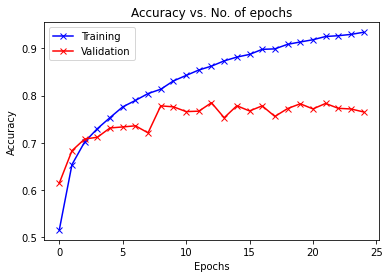

In [87]:
plot_accuracies(history3)

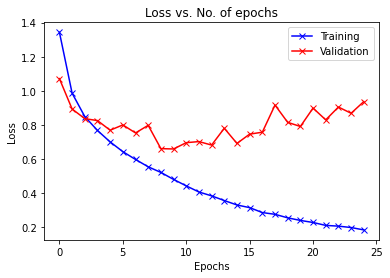

In [88]:
plot_losses(history3)

# Data Tranformation

In [101]:
import torchvision.transforms as tt

# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [102]:
trainset_t = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_tfms)
testset_t = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_tfms)

Files already downloaded and verified
Files already downloaded and verified


In [103]:
# PyTorch datasets
# train_trans = ImageFolder(data_dir+'/train', transform = train_tfms)
# test_trans = ImageFolder(data_dir+'/test', test_tfms)

In [104]:
val_size = 5000
train_size = len(trainset_t) - val_size

train_ds_t, val_ds_t = random_split(trainset_t, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [105]:
batch_size = 400

In [106]:
# PyTorch data loaders
train_dl_t = DataLoader(train_ds_t, batch_size, shuffle=True, pin_memory=True)
val_dl_t = DataLoader(val_ds_t, batch_size*2, pin_memory=True)


In [107]:
train_dl_t = DeviceDataLoader(train_dl_t, device)
val_dl_t = DeviceDataLoader(val_dl_t, device)

In [108]:
model4 = to_device(CNN_batchnorm_dropout(), device)
summary(model4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [109]:
%%time
history4 = fit(num_epochs, lr, model4, train_dl_t, val_dl_t, opt_func)

Epoch [0], train_acc: 0.4126, val_acc: 0.5079, train_loss: 1.6029, val_loss: 1.3498
Epoch [1], train_acc: 0.5567, val_acc: 0.6123, train_loss: 1.2358, val_loss: 1.0855
Epoch [2], train_acc: 0.6078, val_acc: 0.6602, train_loss: 1.0978, val_loss: 0.9786
Epoch [3], train_acc: 0.6423, val_acc: 0.6507, train_loss: 1.0140, val_loss: 0.9718
Epoch [4], train_acc: 0.6608, val_acc: 0.6696, train_loss: 0.9555, val_loss: 0.9436
Epoch [5], train_acc: 0.6771, val_acc: 0.6814, train_loss: 0.9129, val_loss: 0.9061
Epoch [6], train_acc: 0.6925, val_acc: 0.6779, train_loss: 0.8791, val_loss: 0.9321
Epoch [7], train_acc: 0.7011, val_acc: 0.6959, train_loss: 0.8522, val_loss: 0.8718
Epoch [8], train_acc: 0.7126, val_acc: 0.7020, train_loss: 0.8173, val_loss: 0.8451
Epoch [9], train_acc: 0.7202, val_acc: 0.7277, train_loss: 0.8025, val_loss: 0.7655
Epoch [10], train_acc: 0.7276, val_acc: 0.7045, train_loss: 0.7770, val_loss: 0.8477
Epoch [11], train_acc: 0.7327, val_acc: 0.7336, train_loss: 0.7611, val_los

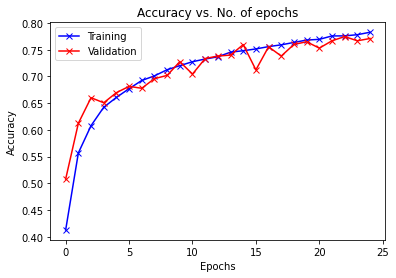

In [110]:
plot_accuracies(history4)

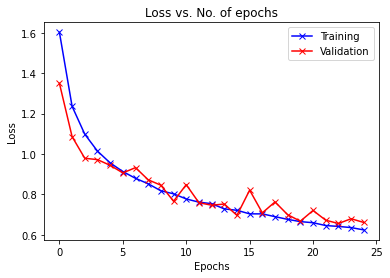

In [111]:
plot_losses(history4)

# Residual Network

In [112]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [113]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [114]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)

            # Compute gradients
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [115]:
model5 = to_device(ResNet9(3, 10), device)
summary(model5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [124]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [125]:
history5 = [evaluate(model5, val_dl_t)]
history

[{'val_loss': 1.3058029413223267,
  'val_acc': 0.5334444046020508,
  'train_loss': 1.6030848026275635,
  'train_acc': 0.4134509265422821},
 {'val_loss': 1.1019655466079712,
  'val_acc': 0.60546875,
  'train_loss': 1.1798346042633057,
  'train_acc': 0.5778956413269043},
 {'val_loss': 0.9453412294387817,
  'val_acc': 0.664878249168396,
  'train_loss': 0.9857762455940247,
  'train_acc': 0.6511082649230957},
 {'val_loss': 0.9170346260070801,
  'val_acc': 0.6665900945663452,
  'train_loss': 0.8690468668937683,
  'train_acc': 0.6953914165496826},
 {'val_loss': 0.8301519751548767,
  'val_acc': 0.7096392512321472,
  'train_loss': 0.7801652550697327,
  'train_acc': 0.7283973097801208},
 {'val_loss': 0.7759414911270142,
  'val_acc': 0.7229434847831726,
  'train_loss': 0.7127850651741028,
  'train_acc': 0.7508606314659119},
 {'val_loss': 0.7915027737617493,
  'val_acc': 0.716636061668396,
  'train_loss': 0.6453418731689453,
  'train_acc': 0.7741920948028564},
 {'val_loss': 0.745832085609436,
  'v

In [126]:
%%time
history5 += fit_one_cycle(epochs, max_lr, model5, train_dl_t, val_dl_t, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_acc: 0.9327, val_acc: 0.8925, train_loss: 0.1974, val_loss: 0.3350
Epoch [1], train_acc: 0.9158, val_acc: 0.8163, train_loss: 0.2438, val_loss: 0.6056
Epoch [2], train_acc: 0.8785, val_acc: 0.7861, train_loss: 0.3573, val_loss: 0.6345
Epoch [3], train_acc: 0.8529, val_acc: 0.7918, train_loss: 0.4363, val_loss: 0.6147
Epoch [4], train_acc: 0.8450, val_acc: 0.6191, train_loss: 0.4632, val_loss: 1.1925
Epoch [5], train_acc: 0.8388, val_acc: 0.7966, train_loss: 0.4812, val_loss: 0.5883
Epoch [6], train_acc: 0.8344, val_acc: 0.7820, train_loss: 0.4869, val_loss: 0.6599
Epoch [7], train_acc: 0.8383, val_acc: 0.7434, train_loss: 0.4804, val_loss: 0.8342
Epoch [8], train_acc: 0.8412, val_acc: 0.7298, train_loss: 0.4728, val_loss: 0.7770
Epoch [9], train_acc: 0.8451, val_acc: 0.8221, train_loss: 0.4482, val_loss: 0.5239
Epoch [10], train_acc: 0.8494, val_acc: 0.7445, train_loss: 0.4436, val_loss: 0.8184
Epoch [11], train_acc: 0.8555, val_acc: 0.8273, train_loss: 0.4241, val_los

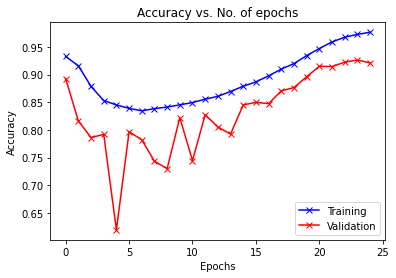

In [127]:
plot_accuracies(history5[1:])

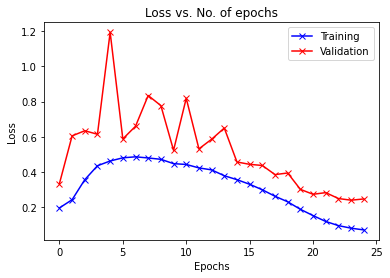

In [128]:
plot_losses(history5[1:])